# Обучение моделей анализа сентимента

In [ ]:
!pip install tensorflow-text
!pip install transformers
!pip install nltk
!pip install pymorphy2

import pandas as pd
import tensorflow as tf
import torch

import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns

import re
import nltk
from nltk.tokenize import word_tokenize 
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool
from catboost.utils import get_confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix
import os
from tensorflow.keras.optimizers import Adam
import tensorflow_hub as hub
import tensorflow_text as text
tf.config.list_physical_devices('GPU')

import pymorphy2

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 60.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 26.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 14.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 KB 6.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 106.8 MB/s eta 0:00:00
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13721 sha256=4d83994a4ddb2966df01a5016498b57297ab402519d912395eb479f3217caa4a
  Stored in directory: /root/.cache/pip/wheels/70/4a/46/1309fc853b8d395e60bafaf1b6df7845bdd82c95fd59dd8d2b
Su

# Загрузка уже обработанных данных c сентиментом

In [ ]:
url = 'googledrive-link'
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
data = pd.read_excel(path)

#data = pd.read_excel('finename.xlsx')

# Предобработка текста
https://webtort.ru/%D0%BF%D1%80%D0%B5%D0%BF%D1%80%D0%BE%D1%86%D0%B5%D1%81%D1%81%D0%B8%D0%BD%D0%B3-%D1%82%D0%B5%D0%BA%D1%81%D1%82%D0%B0-text-preprocessing-%D0%B8%D0%BB%D0%B8-%D0%B3%D0%BE%D1%82%D0%BE%D0%B2%D0%B8%D0%BC/

In [ ]:
def clean_text(text):
    # приводим текст к нижнему регистру
    text = text.lower()
    # создаем регулярное выражение для удаления лишних символов
    regular = r'[\*+\#+\№\"\-+\+\=+\?+\&\^\.+\;\,+\>+\(\)\/+\:\\+]'
    # регулярное выражение для замены ссылки на "URL"
    regular_url = r'(http\S+)|(www\S+)|([\w\d]+www\S+)|([\w\d]+http\S+)'
    # удаляем лишние символы
    text = re.sub(regular, '', text)
    # заменяем ссылки на "URL"
    text = re.sub(regular_url, r'ссылка', text)
    # заменяем числа и цифры на ' NUM '
    text = re.sub(r'(\d+\s\d+)|(\d+)',' 0 ', text)
    # удаляем лишние пробелы
    text = re.sub(r'\s+', ' ', text)
    # возвращаем очищенные данные
    return text
 
# создаем список для хранения преобразованных данных 
processed_text = []

In [ ]:
stop_words = stopwords.words("russian")

In [ ]:
# для каждого сообщения text из столбца data['Message']
def clean_and_unite(message):
    processed_text = []
    for text in message:
        # cleaning 
        text = clean_text(text)   
        # tokenization
        #text = word_tokenize(text) 
        text = text.split(' ')     
        # удаление стоп-слов
        text = [word for word in text if word not in stop_words]
        string = " ".join(text)     
        # лемматизация
        #text = [morph.parse(w)[0].normal_form for w in text]
        # добавляем преобразованный текст в список processed_text
        processed_text.append(string)
    return processed_text
data.rename(columns={'message': 'text'}, inplace=True)
data['text'] = data['text'].apply(clean_and_unite)

,Unnamed: 0,index,id,date,message,views,forwards,Unnamed: 14,Unnamed: 15
0,0,16,16975.0,2022-12-14T16:35:34+00:00,📊 потенциал роста акций applied materials огра...,12590.0,5.0,👍,15.0
1,1,17,16974.0,2022-12-14T15:09:21+00:00,видим вероятность роста бумаг тмк 0 – 0 % гори...,11947.0,13.0,👍,25.0
2,2,18,16973.0,2022-12-14T14:03:44+00:00,ближайшие дни начинается очередной налоговый п...,11419.0,13.0,👍,26.0
3,3,19,16972.0,2022-12-14T13:18:44+00:00,📈oracle corporation orcl специализируется выпу...,10595.0,4.0,👍,15.0
4,4,20,16971.0,2022-12-14T11:15:14+00:00,📊 пао «татнефть» тикер tatn идея long ⬆️ гориз...,10835.0,38.0,👍,44.0
...,...,...,...,...,...,...,...,...,...
104893,104893,114533,8.0,2020-01-17T09:26:17+00:00,лукойл фигура отыграла цель 0 достигнута⭐️😉,428.0,0.0,NaN,NaN
104894,104894,114534,6.0,2020-01-17T08:39:34+00:00,новатек лонг тейк 0 стоп 0 цена 0,426.0,0.0,NaN,NaN
104895,104895,114535,5.0,2020-01-17T08:27:04+00:00,сбербанк пр лонгтейк 0 стоп 0 цена 0,357.0,0.0,NaN,NaN
104896,104896,114536,4.0,2020-01-17T07:55:19+00:00,сбербанк лонг тейк 0 стоп 0 закрытый геп возмо...,340.0,0.0,NaN,NaN


# Основаная: Catboost vs BERT
Яндекс-модель для анализа сентиментов

https://habr.com/ru/post/555064/
https://github.com/sagol/catboost_sentiment/blob/main/catboost_sentiment_analysis.ipynb


In [ ]:
!pip install catboost
!pip install cuda-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 13.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.9/18.9 MB 56.0 MB/s eta 0:00:00


In [ ]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = 'true'

In [ ]:
# Создаем fit_model с параметрами
def fit_model(train_pool, test_pool, **kwargs):
    model = CatBoostClassifier(
        task_type='GPU',
        iterations=10000,
        eval_metric='Accuracy',
        od_type='Iter',
        od_wait=500,
        **kwargs)

    return model.fit(
        train_pool,
        eval_set=test_pool,
        verbose=100,
        plot=True,
        use_best_model=True)

In [ ]:
df = data.copy()

In [ ]:
# Делаем train and test
df_train = df.loc[df.dtype == "train"][['text', 'label']]
df_test = df.loc[df.dtype == "test"][['text', 'label']]

In [ ]:
train, valid = train_test_split(
    df_train,
    train_size=0.6,
    random_state=0,
    stratify=df_train['label'])

y_train, X_train = \
    train['label'], train.drop(['label'], axis=1)
y_valid, X_valid = \
    valid['label'], valid.drop(['label'], axis=1)

In [ ]:
train_pool = Pool(
    data=X_train,
    label=y_train,
    text_features=['text']
)

valid_pool = Pool(
    data=X_valid, 
    label=y_valid,
    text_features=['text']
)

test_pool = Pool(
    data=df_test[[c for c in df_test.columns if c!='label']][['text']], 
    label=df_test['label'],
    text_features=['text']
)

In [ ]:
# Фиттим модель
model = fit_model(
    train_pool, valid_pool,
    learning_rate=0.4, #0.35
    tokenizers=[
        {
            'tokenizer_id': 'Sense',
            'separator_type': 'BySense',
            'lowercasing': 'True',
            'token_types':['Word', 'Number', 'SentenceBreak'],
            'sub_tokens_policy':'SeveralTokens'
        }      
    ],
    dictionaries = [
        {
            'dictionary_id': 'Word',
            'max_dictionary_size': '50000'
        }
    ],
    feature_calcers = [
        'BoW:top_tokens_count=10000'
    ]
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.7487307	test: 0.7443531	best: 0.7443531 (0)	total: 23.5ms	remaining: 3m 54s
100:	learn: 0.7540388	test: 0.7403721	best: 0.7443531 (0)	total: 1.12s	remaining: 1m 49s
200:	learn: 0.7603277	test: 0.7395932	best: 0.7443531 (0)	total: 2.12s	remaining: 1m 43s
300:	learn: 0.7650012	test: 0.7392471	best: 0.7443531 (0)	total: 3.04s	remaining: 1m 38s
400:	learn: 0.7715786	test: 0.7401990	best: 0.7443531 (0)	total: 3.96s	remaining: 1m 34s
500:	learn: 0.7748096	test: 0.7395067	best: 0.7443531 (0)	total: 4.9s	remaining: 1m 32s
bestTest = 0.7443530939
bestIteration = 0
Shrink model to first 1 iterations.


# Метрики CatBoost



1.   bestTest = 0.7469712703 (0.35)
2.   bestTest = 0.7577854671 (0.35)




In [ ]:
y_proba_cb = model.predict_proba(test_pool)
y_pred = np.argmax(y_proba_cb, axis=1)
df_test['predict'] = model.predict(test_pool)

In [ ]:
acc = model.score(test_pool)
print(f"CatBoost model accuracy: {acc}")

CatBoost model accuracy: 0.7504672897196262


## Сравниваем разные learning rate
CatBoost model accuracy: 0.7461059190031153 (0.5 learning rate)

CatBoost model accuracy: 0.7495327102803738 (0.35 learning rate)

CatBoost model accuracy: 0.75202492211838 (0.4 learning rate)

## Анализируем confusion matrix

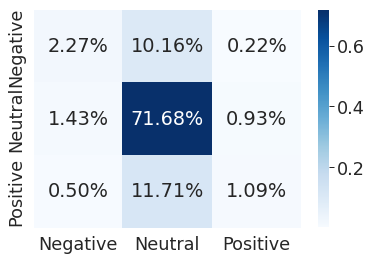

In [ ]:
target_names = ['Negative', 'Neutral', 'Positive']
y_true = df_test['label'].astype('category').cat.codes.values
cf_matrix = get_confusion_matrix(model, test_pool)
sns.heatmap(
    cf_matrix/np.sum(cf_matrix),
    annot=True, fmt='.2%', cmap='Blues',
    xticklabels=target_names,
    yticklabels=target_names)

In [ ]:
print('\nClassification Report For Catboost')
target_names = ['Negative', 'Neutral', 'Positive']
print(classification_report(
    df_test['label'].astype('category').cat.codes.values,
    y_pred, target_names=target_names))


Classification Report For Catboost
              precision    recall  f1-score   support

    Negative       0.54      0.18      0.27       406
     Neutral       0.77      0.97      0.86      2377
    Positive       0.49      0.08      0.14       427

    accuracy                           0.75      3210
   macro avg       0.60      0.41      0.42      3210
weighted avg       0.70      0.75      0.69      3210



# Сохраняем модель

In [ ]:
fname = "model_cb.cbm"
model.save_model(fname,
           format="cbm",
           export_parameters=None,
           pool=None)

In [ ]:
#from google.colab import files
#files.download('model_cb.cbm') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Далее идут дополнительные модели, которые либо не работают, либо работают плохо

# BERT-Model против CAtBoost

In [ ]:
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification
tfhub_handle_encoder = \
    "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1"
tfhub_handle_preprocess = \
    "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"

# tfhub_handle_encoder = \
#       "https://huggingface.co/sberbank-ai/ruRoberta-large"
# tfhub_handle_preprocess = \
#       "https://huggingface.co/sberbank-ai/ruRoberta-large"
# tokenizer_sd = AutoTokenizer.from_pretrained(MODEL)# , add_prefix_space=True) #, use_fast = False)
# model_sd = AutoModelForSequenceClassification.from_pretrained(MODEL)


In [ ]:
def build_classifier_model():
    
    text_input = tf.keras.layers.Input(
        shape=(), dtype=tf.string, name='text')
    
    preprocessing_layer = hub.KerasLayer(
        tfhub_handle_preprocess, name='preprocessing')
    
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(
        tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(
        3, activation='softmax', name='classifier')(net)
    model = tf.keras.Model(text_input, net) ###
    
    loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    metric = tf.metrics.CategoricalAccuracy('accuracy')
    optimizer = tf.keras.optimizers.legacy.Adam(
        learning_rate=5e-05, epsilon=1e-08, decay=0.01, clipnorm=1.0)
    model.compile(
        optimizer=optimizer, loss=loss, metrics=metric)
    model.summary()
    return model
classifier_model = build_classifier_model()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128)}                                                

In [ ]:
y_train_c = tf.keras.utils.to_categorical(
    y_train.astype('category').cat.codes.values, num_classes=3)
y_valid_c = tf.keras.utils.to_categorical(
    y_valid.astype('category').cat.codes.values, num_classes=3)


In [ ]:
history = classifier_model.fit(
    x=X_train['text'].values,
    y=y_train_c,
    validation_data=(X_valid['text'].values, y_valid_c),
    epochs=5)

Epoch 1/5


/usr/local/lib/python3.8/dist-packages/keras/backend.py:5534: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


542/542 [==============================] - 165s 292ms/step - loss: 0.7596 - accuracy: 0.7384 - val_loss: 0.7061 - val_accuracy: 0.7416
Epoch 2/5
542/542 [==============================] - 152s 281ms/step - loss: 0.7284 - accuracy: 0.7402 - val_loss: 0.6975 - val_accuracy: 0.7396
Epoch 3/5
542/542 [==============================] - 153s 283ms/step - loss: 0.7101 - accuracy: 0.7408 - val_loss: 0.6814 - val_accuracy: 0.7434
Epoch 4/5
542/542 [==============================] - 151s 279ms/step - loss: 0.6929 - accuracy: 0.7424 - val_loss: 0.6767 - val_accuracy: 0.7433
Epoch 5/5
542/542 [==============================] - 158s 292ms/step - loss: 0.6903 - accuracy: 0.7437 - val_loss: 0.6833 - val_accuracy: 0.7428


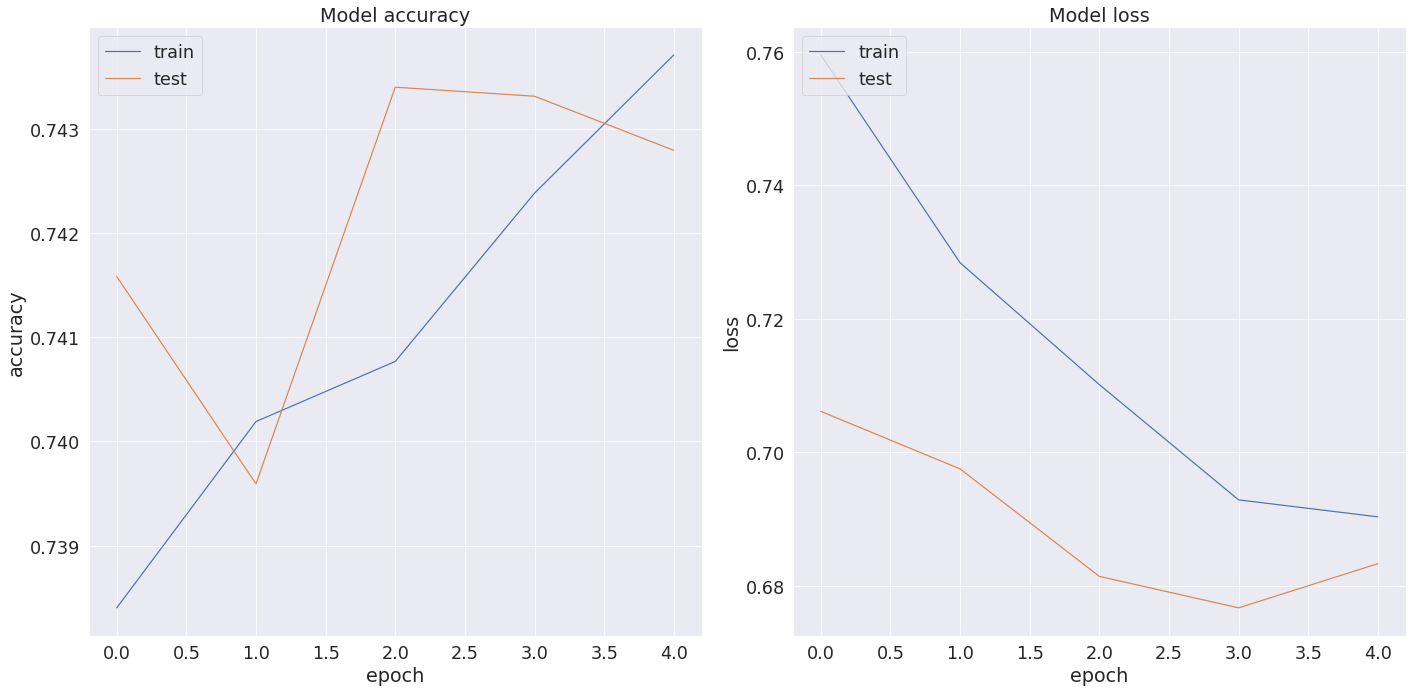

In [ ]:
sns.set()
sns.set_context("paper", font_scale=2) 

fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(121)
sns.lineplot(ax=ax1, data=history.history['accuracy'])
sns.lineplot(ax=ax1, data=history.history['val_accuracy'])
ax1.set(
    title=f"Model accuracy",
    xlabel="epoch",
    ylabel="accuracy"
)
ax1.legend(['train', 'test'], loc='upper left')
ax2 = fig.add_subplot(122)
sns.lineplot(ax=ax2, data=history.history['loss'])
sns.lineplot(ax=ax2, data=history.history['val_loss'])
ax2.set(
    title=f"Model loss",
    xlabel="epoch",
    ylabel="loss"
)
ax2.legend(['train', 'test'], loc='upper left')

fig.tight_layout()
plt.show(fig) 

In [ ]:
y_test_c = tf.keras.utils.to_categorical(
    df_test['label'].astype('category').cat.codes.values, num_classes=3)

e = classifier_model.evaluate(x=df_test['text'].values, y=y_test_c)

101/101 [==============================] - 10s 101ms/step - loss: 0.6874 - accuracy: 0.7430


In [ ]:
print(f"BERT Accuracy: {e[1]}")

BERT Accuracy: 0.7429906725883484


In [ ]:
y_true = df_test['label'].astype('category').cat.codes.values

In [ ]:
y_proba_bert = classifier_model.predict(df_test['text'].values)
y_pred_bert = np.argmax(y_proba_bert, axis=1)

101/101 [==============================] - 10s 96ms/step


In [ ]:
target_names = ['Negative', 'Neutral', 'Positive']
print(classification_report(y_true, y_pred_bert, target_names=target_names))

              precision    recall  f1-score   support

    Negative       0.49      0.24      0.32       406
     Neutral       0.79      0.93      0.85      2377
    Positive       0.37      0.18      0.25       427

    accuracy                           0.74      3210
   macro avg       0.55      0.45      0.47      3210
weighted avg       0.70      0.74      0.71      3210



In [ ]:
from sklearn.metrics import accuracy_score
y_proba_cb = model.predict_proba(test_pool)
y_proba_avg = np.argmax((y_proba_cb + y_proba_bert)/2, axis=1)
print(f'Average accuracy: {accuracy_score(y_true, y_proba_avg)}')

Average accuracy: 0.746417445482866


# Sber bert model
Сберовская модель, которая определяет сентимент на основе дополнительной метрики меры информации. Не работает для длинных сообщений

In [ ]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import math
import pandas as pd

In [ ]:
#загрузка моделей из hugging face
tokenizer = GPT2Tokenizer.from_pretrained("sberbank-ai/rugpt3large_based_on_gpt2", add_prefix_space=True)
gpt3_large = GPT2LMHeadModel.from_pretrained("sberbank-ai/rugpt3large_based_on_gpt2")
#gpt3_large = gpt3_large.to(device)

In [ ]:
def calculate_perplexity(sentence, model, tokenizer):
    sentence_positive = 'довольна:'+sentence               
    sentence_negative = 'недовольна:'+sentence               
    list_sent = [sentence_positive, sentence_negative]
    ppl_values = []

    for sentence in list_sent:
        encodings = tokenizer(sentence, return_tensors='pt')
        input_ids = encodings.input_ids #.to(device)
        with torch.no_grad():
            outputs = gpt3_large(input_ids=input_ids, labels=input_ids)
        loss = outputs.loss
        try:
            ppl = math.exp(loss.item() * input_ids.size(1)) #было произведение
        except OverflowError:
            ppl = float(10**100)
        ppl_values.append(ppl)
    
    if ppl_values[0] > ppl_values[1]:
        return "отрицательный" # отрицательный ppl_values[1] - ppl_values[0] 
    elif ppl_values[0] < ppl_values[1]:
        return  1 # положительный ppl_values[1] - ppl_values[0]

In [ ]:
data = pd.DataFrame()
data = data_proc; data
data['post_proc'] = data['post_proc'].astype("str")

In [ ]:
#reviews = pd.read_excel('путь_до_файла_с_данными')
#reviews['sentiment'] = reviews['review'].apply(lambda x: calculate_perplexity(x, gpt3_large, tokenizer))

data['sentiment'] = data['post_proc'].apply(lambda x: calculate_perplexity(x, gpt3_large, tokenizer))

In [ ]:
data

,sentiment
8,None
9,None
10,None
11,None


In [ ]:
# from sklearn import preprocessing

# array = np.array(reviews['sentiment'])
# #reviews['sentiment'] = scaler.transform(reviews['sentiment'])
# reviews

# x_array = np.array(reviews['sentiment'])
# normalized_arr = preprocessing.normalize([x_array])

# print(normalized_arr)

[[ 1.00000000e+00  9.68119447e-23  1.32897196e-22 -1.27344342e-22
  -9.23045582e-22 -7.82784472e-21]]


# TextBlob
Работает только с англйиским

https://dev-gang.ru/article/analiz-tonalnosti-v-python-s-pomosczu-textblob-gig60q9gat/

In [ ]:
! pip install textblob

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer

sentence = "Very bad stock"

blob_object = TextBlob(sentence, analyzer=NaiveBayesAnalyzer())

analysis = blob_object.sentiment
print(analysis)


**********************************************************************
  Resource movie_reviews not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('movie_reviews')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load corpora/movie_reviews

  Searched in:
    - '/root/nltk_data'
    - '/usr/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
**********************************************************************



MissingCorpusError: ignored

# Dostoevsky
Определяет neg, pos, neutral. Но пока видимая проблема в том, что нет ярко окрашенных негативных или позитивных сообщений, что с другой стороны нормально, так как выбросы будут очень редкими

https://leftjoin.ru/all/constitution-sentiment-analysis/
https://github.com/bureaucratic-labs/dostoevsky


In [ ]:
!pip install dostoevsky

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 KB 6.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached pybind11-2.10.3-py3-none-any.whl (222 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp38-cp38-linux_x86_64.whl size=4397803 sha256=346bed02cfb08cb35877e9d3dcdff3edda9fd49b6e58aaacb98651235d23b930
  Stored in directory: /root/.cache/pip/wheels/93/61/2a/c54711a91c418ba06ba195b1d78ff24fcaad8592f2a694ac94
Successfully built fasttext


In [ ]:
from dostoevsky.tokenization import RegexTokenizer
from dostoevsky.models import FastTextSocialNetworkModel
import pandas as pd

In [ ]:
!python -m dostoevsky download fasttext-social-network-model

In [ ]:
res_dost = tmp.iloc[100:125]

In [ ]:
dost = pd.DataFrame()
dost = data_proc[100:125] 
for i in range(100,125):
  dost['post_proc'][i] = " ".join(data_proc['post_proc'][i])


In [ ]:
tokenizer = RegexTokenizer()
model = FastTextSocialNetworkModel(tokenizer=tokenizer)
sentiment_list = []
results = model.predict(res_dost['message'], k=2)
for sentiment in results:
    sentiment_list.append(sentiment)

In [ ]:
neutral_list = []
negative_list = []
positive_list = []
speech_list = []
skip_list = []
for sentiment in sentiment_list:
    neutral = sentiment.get('neutral')
    negative = sentiment.get('negative')
    positive = sentiment.get('positive')
    if neutral is None:
        neutral_list.append(0)
    else:
        neutral_list.append(sentiment.get('neutral'))
    if negative is None:
        negative_list.append(0)
    else:
        negative_list.append(sentiment.get('negative'))
    if positive is None:
        positive_list.append(0)
    else:
        positive_list.append(sentiment.get('positive'))
res_dost['neutral'] = neutral_list
res_dost['negative'] = negative_list
res_dost['positive'] = positive_list
#res_dost = pd.merge(left = data, right = res_dost, right_index=True, left_index=True); res_dost

<ipython-input-186-51fcd1bd8666>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_dost['neutral'] = neutral_list
<ipython-input-186-51fcd1bd8666>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_dost['negative'] = negative_list
<ipython-input-186-51fcd1bd8666>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_

In [ ]:
res_dost

,index,id,date,message,views,forwards,Unnamed: 14,Unnamed: 15,neutral,negative,positive
100,116,16871.0,2022-11-23T11:31:16+00:00,📊 Duke Energy Corporation\nТикер: DUK\nИдея: L...,12411.0,6.0,👍,19,0.831153,0.106701,0
101,117,16870.0,2022-11-23T10:30:41+00:00,📊 ПАО «Дальневосточное морское пароходство»\nТ...,12247.0,32.0,👍,39,0.754925,0.160276,0
102,118,16869.0,2022-11-23T09:41:34+00:00,📈Фьючерсы на природный газ (NGX2): потенциальн...,12337.0,13.0,👍,27,0.798197,0.187143,0
103,119,16868.0,2022-11-23T08:26:12+00:00,"«Норникель» борется за уровень 15000 рублей, т...",13838.0,5.0,👍,53,0.712242,0.191943,0
104,120,16867.0,2022-11-22T17:00:42+00:00,Встреча с Ozon: бизнес в новых условиях\n\n🤝Мы...,14537.0,7.0,👍,23,0.859674,0.073706,0
105,121,16866.0,2022-11-22T14:45:36+00:00,"📈Baidu, Inc. (BIDU): китайская компания, предо...",13678.0,4.0,👍,33,0.782673,0.125933,0
106,122,16865.0,2022-11-22T13:58:05+00:00,📉 Экспортные ограничения США снижают потенциал...,12758.0,1.0,👍,20,0.718604,0.132974,0
107,123,16864.0,2022-11-22T13:22:34+00:00,Цифры по банковскому сектору за октябрь указыв...,12711.0,3.0,👍,21,0.867046,0.106701,0
108,124,16863.0,2022-11-22T11:40:19+00:00,📊ПАО «МТС»\nТикер: MTSS\nИдея: Long⬆️\nГоризон...,12821.0,41.0,👍,66,0.812877,0.106701,0
109,125,16862.0,2022-11-22T11:01:22+00:00,📊Deere & Company\nТикер: DE\nИдея: Long⬆️\nГор...,12945.0,6.0,👍,12,0.817585,0.082707,0


#Bert model
bert-base-multilingual-cased. Нужно поиграться с моделью. Эта плохо работает с русским языком. Надо пробовать сберовские, но они медленные

Проверка моделей:


1.   yandex/RuLeanALBERT надо переписать код)
2.   sberbank-ai/ruT5-large (не работает)
3.   **sberbank-ai/ruRoberta-large (работает)**
4.   sberbank-ai/ruT5-base (не работает)
5. sberbank-ai/ruBert-large (работает плохо)





In [ ]:
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification
MODEL = "sberbank-ai/ruRoberta-large"
tokenizer_sd = AutoTokenizer.from_pretrained(MODEL)# , add_prefix_space=True) #, use_fast = False)
model_sd = AutoModelForSequenceClassification.from_pretrained(MODEL)


Some weights of the model checkpoint at sberbank-ai/ruRoberta-large were not used when initializing RobertaForSequenceClassification: ['lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.decoder.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at sberbank-ai/ruRoberta-large and are newly initialized: ['classifier.dense.weight', 'classifier.out_

In [ ]:
def sentiment_score(message):
    tokens = tokenizer_sd.encode(message, return_tensors='pt') #, is_split_into_words=True)
    result = model_sd(tokens)
    return int(torch.argmax(result.logits))+1

In [ ]:
res_sbert = pd.DataFrame()
kek = df_train.copy()
#data = data.dropna()
kek['sentiment'] = kek['text'][:50].apply(lambda x: sentiment_score(x[:512]))

TypeError: ignored

In [ ]:
#data['sentiment'] = data['sentiment'] - 1
#res_sbert = data; res_sbert[:100]
kek

,text,label,sentiment
0,И где хранить?)) А контракты бы купил где-нибу...,2.0,2.0
1,"А, кстати, про втб. У меня мысль последнее вре...",2.0,1.0
2,Очень приятно слышать человека именно тем сост...,2.0,1.0
3,покупаем покупаем страшно недооценен . дивоход...,3.0,1.0
4,весьма интересно посмотреть постаукцион,2.0,1.0
...,...,...,...
32569,Смотреть торговать не одно тоже.Всех благ,2.0,NaN
32570,Не повторяйте этот бред. До развала СССР довел...,2.0,NaN
32571,"пропал, дела",2.0,NaN
32573,УДС – уровень достаточности средств Стоимость ...,2.0,NaN


In [ ]:
res_sbert = res_sbert.merge(tmp, left_index=True, right_index=True)


In [ ]:
#res_sbert[['label']] = res_sbert[['label']].astype(int)
#res = res_sbert[["message", 'sentiment','label2','dtype']][:100]
from sklearn.metrics import accuracy_score
accuracy_score(kek['label2'], kek['sentiment'])
#import matplotlib.pyplot as plt
#plt.plot(res.index, res['label2'])
#plt.plot(res.index, res['sentiment'])

0.28

In [ ]:
tmp.loc[tmp.label == 1]

,message,label,count,dtype
8,"Нефть среду 40 собралась, льют, плюс санкции",1.0,11.0,train
16,шорты!!! счастье!!!,1.0,6.0,train
23,Мультиплицируется эффект падения. Вы чего? Ник...,1.0,50.0,train
25,"Джо появился, шорту ... так-то шутка, каждой ш...",1.0,16.0,train
38,"Ага, 8140. Тейк лоу дня.",1.0,7.0,train
...,...,...,...,...
32490,"оборонять будут сильно, из крупняка решит сыгр...",1.0,29.0,train
32494,Сургут вроде скоро упрется верхнюю границу нис...,1.0,22.0,train
32523,одна из составляющих получения профита - увере...,1.0,34.0,train
32550,не маловато? ) чего он должен +5 сделать? сбер...,1.0,26.0,train


In [ ]:
#res_sbert.to_csv("Sber_model.csv", sep=",")
#files.download("Sber_model.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>